In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import process_label

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = (
    metadata.group_by("eeg_id")
    .agg(
        *[
            pl.col(f"{label}_prob_per_eeg").first().alias(f"gt_{label}_prob")
            for label in LABELS
        ],
        pl.col("weight_per_eeg").first().alias("weight"),
    )
    .filter(pl.col("weight").ge(0.3))
)
display(metadata.head())


def sum_over_labels(labels) -> pl.Expr:
    x = pl.lit(0.0)
    for label in labels:
        x += pl.col(f"pl_{label}_vote")
    return x


df = pl.read_parquet("../data/pseudo_label/v5_eeg_24ep_cutmix/train_pseudo_label.pqt")
df = (
    df.with_columns(pl.col(f"pl_{label}_vote").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"pl_{label}_vote").truediv(pl.col("pl_vote")).alias(f"{label}_prob")
        for label in LABELS
    )
)


metadata = df.join(metadata, on="eeg_id")
display(metadata.head())

eeg_id,gt_seizure_prob,gt_lpd_prob,gt_gpd_prob,gt_lrda_prob,gt_grda_prob,gt_other_prob,weight
i64,f64,f64,f64,f64,f64,f64,f64
2025500940,0.006472,0.446602,0.0,0.440129,0.0,0.106796,0.40873
1575093823,0.076923,0.076923,0.692308,0.0,0.0,0.153846,0.464286
672742669,0.0,0.0,0.0,0.0,0.218391,0.781609,0.345238
945186381,0.0,0.0,0.0,0.0,0.0,1.0,0.714286
876238217,0.0625,0.0,0.6875,0.0,0.0,0.25,0.571429


eeg_id,pl_seizure_vote,pl_lpd_vote,pl_gpd_vote,pl_lrda_vote,pl_grda_vote,pl_other_vote,pl_vote,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,gt_seizure_prob,gt_lpd_prob,gt_gpd_prob,gt_lrda_prob,gt_grda_prob,gt_other_prob,weight
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
8027281,0.09522,4.200574,0.302068,0.45147,0.280141,2.136036,7.465509,0.012755,0.562664,0.040462,0.060474,0.037525,0.286121,0.0,0.785714,0.0,0.142857,0.0,0.071429,0.5
10617205,0.08436,0.049015,0.096155,0.292631,7.891254,7.814567,16.227982,0.005198,0.00302,0.005925,0.018033,0.486275,0.481549,0.0,0.0,0.0,0.0,0.416667,0.583333,0.428571
14623517,6.721245,0.33273,6.824867,0.028777,0.173831,0.489747,14.571198,0.461269,0.022835,0.468381,0.001975,0.01193,0.033611,0.533333,0.0,0.4,0.0,0.0,0.066667,0.535714
15073201,0.199298,0.15812,0.406907,0.149413,0.64376,9.750746,11.308244,0.017624,0.013983,0.035983,0.013213,0.056928,0.862269,0.0,0.0,0.058824,0.0,0.058824,0.882353,0.607143
17311157,0.089684,0.060605,0.24626,0.18462,2.943951,8.062628,11.587749,0.00774,0.00523,0.021252,0.015932,0.254057,0.695789,0.0,0.0,0.0,0.0,0.153846,0.846154,0.464286


In [3]:
from src.metric import calc_kl_div_score

gt_df = (
    metadata.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select("eeg_id", *[f"{label}_vote" for label in LABELS])
    .to_pandas()
)
pred_df = (
    metadata.with_columns(
        [pl.col(f"{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select("eeg_id", *[f"{label}_vote" for label in LABELS])
    .to_pandas()
)
calc_kl_div_score(gt_df, pred_df, "eeg_id")

0.23518765901690628

In [4]:
from scipy.special import kl_div
import pandas as pd


gts = metadata.select([f"gt_{label}_prob" for label in LABELS]).to_numpy()
preds = metadata.select([f"{label}_prob" for label in LABELS]).to_numpy()
eeg_ids = metadata.get_column("eeg_id").to_numpy()


def calc_score(gts, preds, eeg_ids):
    gt_df = pd.DataFrame(gts, columns=LABELS)
    gt_df["eeg_id"] = eeg_ids
    pred_df = pd.DataFrame(preds, columns=LABELS)
    pred_df["eeg_id"] = eeg_ids
    return calc_kl_div_score(gt_df, pred_df, "eeg_id")


calc_score(gts, preds, eeg_ids)

0.23518765901690628

## Discretized Annealing

243


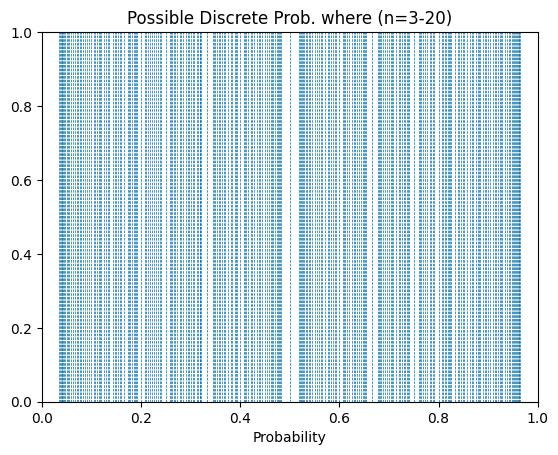

In [5]:
discretized_values = set()
vote_min = 3
vote_max = 28
for n in range(vote_min, vote_max + 1):
    for k in range(0, n + 1):
        if k / n in discretized_values:
            continue
        discretized_values.add(k / n)

print(len(discretized_values))

_, ax = plt.subplots()
for x in discretized_values:
    ax.axvline(x, 0, 1, linestyle="--", linewidth=0.5)

ax.set(xlabel="Probability", title="Possible Discrete Prob. where (n=3-20)")
plt.show()

### 確率が最小のクラスを0で置換する

In [6]:
def replace_min_with_zero(preds: np.ndarray) -> np.ndarray:
    preds = preds.copy()
    min_indices = np.argmin(preds, axis=1)

    for row, col in enumerate(min_indices):
        preds[row, col] = 0

    preds /= preds.sum(axis=1, keepdims=True)

    return preds

In [7]:
pp_preds = replace_min_with_zero(preds)
calc_score(gts, pp_preds, eeg_ids)

0.3864625728084802

### 確率が閾値以上のクラスを1で置換する

In [8]:
def replace_larger_than_threshold_with_one(
    preds: np.ndarray, threshold: float = 0.95
) -> np.ndarray:
    preds = preds.copy()
    preds[preds >= threshold] = 1
    preds /= preds.sum(axis=1, keepdims=True)

    return preds

In [9]:
pp_preds = replace_larger_than_threshold_with_one(preds, 0.95)
calc_score(gts, pp_preds, eeg_ids)

0.2351757092559891

In [10]:
min_score = float("inf")
best_threshold = float("inf")

for threshold in np.linspace(0.8, 1.0, 50):
    pp_preds = replace_larger_than_threshold_with_one(preds, threshold)
    score = calc_score(gts, pp_preds, eeg_ids)
    if score < min_score:
        min_score = score
        best_threshold = threshold

print(min_score, best_threshold)

0.23484461515118196 0.8204081632653062


### 閾値以下のクラスを0で置換する

In [11]:
def replace_less_than_threshold_with_zero(
    preds: np.ndarray, threshold: float = 0.1
) -> np.ndarray:
    preds = preds.copy()
    preds[preds < threshold] = 0
    preds /= preds.sum(axis=1, keepdims=True)

    return preds

In [12]:
min_score = float("inf")
best_threshold = float("inf")

for threshold in np.linspace(0.0, 0.05, 20):
    pp_preds = replace_less_than_threshold_with_zero(preds, threshold)
    score = calc_score(gts, pp_preds, eeg_ids)
    if score < min_score:
        min_score = score
        best_threshold = threshold

print(min_score, best_threshold)

0.235187649061752 0.0


### 最も近い離散的な値で置換する

In [13]:
def replace_with_nearest_discretized_value(
    preds, discretized_values, tolerance: float = 0.01
):
    preds = preds.copy()
    discretized_values = np.array(list(discretized_values))

    def find_and_replace(value):
        differences = np.abs(discretized_values - value)
        index_min = np.argmin(differences)
        if differences[index_min] < tolerance:
            return discretized_values[index_min]
        else:
            return value

    vectorized_func = np.vectorize(find_and_replace)
    preds = vectorized_func(preds)
    preds /= preds.sum(axis=1, keepdims=True)

    return preds

In [14]:
min_score = float("inf")
best_torelance = float("inf")
n_annealing = 1

for tolerance in np.linspace(0.0, 0.1, 50):
    pp_preds = preds.copy()
    for _ in range(n_annealing):
        pp_preds = replace_with_nearest_discretized_value(
            preds, discretized_values, tolerance
        )
    score = calc_score(gts, pp_preds, eeg_ids)
    if score < min_score:
        min_score = score
        best_torelance = tolerance

print(min_score, best_torelance)

0.235187649061752 0.0


### 効いたやつ全部

In [15]:
from functools import partial

import optuna


def objective(
    trial: optuna.Trial,
    preds: np.ndarray,
) -> float:
    pp_preds = preds.copy()
    max_threshold = trial.suggest_float("max_threshold", 0.8, 1.0)

    pp_preds = replace_larger_than_threshold_with_one(pp_preds, max_threshold)
    return calc_score(gts, pp_preds, eeg_ids)

In [16]:
study = optuna.create_study(direction="minimize")
study.optimize(
    partial(
        objective,
        preds=preds,
    ),
    n_trials=50,
    show_progress_bar=True
)

[I 2024-03-28 15:23:20,310] A new study created in memory with name: no-name-8d8ded95-7e4c-42a5-a774-978a606e61fd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-03-28 15:23:20,327] Trial 0 finished with value: 0.23495934779751113 and parameters: {'max_threshold': 0.8651979908753032}. Best is trial 0 with value: 0.23495934779751113.
[I 2024-03-28 15:23:20,339] Trial 1 finished with value: 0.2348676935793555 and parameters: {'max_threshold': 0.8382936140027795}. Best is trial 1 with value: 0.2348676935793555.
[I 2024-03-28 15:23:20,352] Trial 2 finished with value: 0.2348650236737232 and parameters: {'max_threshold': 0.838058497263161}. Best is trial 2 with value: 0.2348650236737232.
[I 2024-03-28 15:23:20,364] Trial 3 finished with value: 0.23518792030486008 and parameters: {'max_threshold': 0.9792226548246883}. Best is trial 2 with value: 0.2348650236737232.
[I 2024-03-28 15:23:20,376] Trial 4 finished with value: 0.23518815526715445 and parameters: {'max_threshold': 0.9779960110205174}. Best is trial 2 with value: 0.2348650236737232.
[I 2024-03-28 15:23:20,388] Trial 5 finished with value: 0.23485195361907396 and parameters: {'max_thr

In [17]:
study.best_params

{'max_threshold': 0.8218795560250578}

In [18]:
study.best_value

0.23484210852735207

In [19]:
pp_preds = preds.copy()
pp_preds = replace_larger_than_threshold_with_one(pp_preds, 0.8224261767310831)
score = calc_score(gts, pp_preds, eeg_ids)
score

0.23484593080263397

## 結論

* 「予測確率は量子化された値のいずれかをとる」という弱い仮定のみからは意味のあるゲインを引き出せず
* trainのラベルの値の分布を加味した強い仮定を用いればもう少しゲインは出るかもしれない(overfitのリスクあり)